In [1]:
import numpy as np

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1) # quadratic equation + gaussian noise

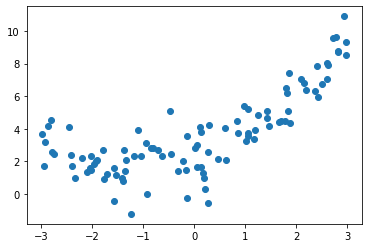

In [2]:
import matplotlib.pyplot as plt

plt.scatter(X, y)

In [3]:
X[0] ** 2

array([0.87606146])

### Enabling a linear regression model to find relationships of multiple features
- transform the training set to where each instance has all the combinations of features up to the given degree
    - e.g. two features a and b (meaning degree == 3 b/c intercept + a + b) would have polynomial features a^2, a^3, b^2, b^3, ab, a^2b, ab^2

In [4]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2)
X_full = poly_features.fit_transform(X) #add the different combinations of X to a given degree (this case 2) as features
print(X_full[0])

[ 1.         -0.93598155  0.87606146]


the result is an array [1, X, X<sup>2</sup>]

In [5]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_full, y)
print(lin_reg.intercept_, lin_reg.coef_)

[2.23319129] [[0.         1.02995056 0.45085464]]


### how to pick the correct order for polynomial regression
- Data driven means using data to figure out which one is the best. We usually have training set and testing set. There are some other variations, such as adding one additional validation data set, run repeated cross validation etc. But the overall idea is and pick the best one in testing set, and we can make sure testing set is very close to production data.

- Knowledge driven means using "domain knowledge" to make the decision on parameter tuning. For example, we are fitting some data from some trajectory data and we know our data from physics would generally follow a parabola trend, not a 5th order polynomial curve. Then we would like pick the 2nd order polynomial to fit. In addition, if we know our data is periodic, we may choose Fourier expansion on the data instead of polynomials. See this post What's wrong to fit periodic data with polynomials?

### **Learning Curve**

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curve(model, X, y):
    train_mse, test_mse = [], []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    for m in range(1, len(X)):
        model.fit(X_train[:m], y_train[:m])
        y_train_pred = model.predict(X_train[:m])
        y_test_pred = model.predict(X_test)
        y_train_mse = mean_squared_error(y_train[:m], y_train_pred)
        y_test_mse = mean_squared_error(y_test, y_test_pred)
        train_mse.append(y_train_mse)
        test_mse.append(y_test_mse)
    plt.plot(np.sqrt(train_mse), "r-+", label="Training set")
    plt.plot(np.sqrt(test_mse), "b-", label="Test set")
    plt.legend(loc="upper right")

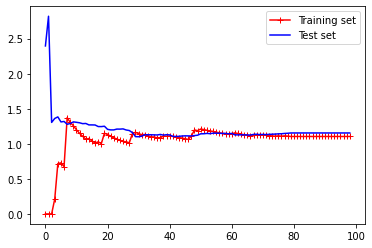

In [7]:
lin_reg = LinearRegression()
plot_learning_curve(lin_reg, X_full, y) #if I used the training set w/o polynomial features then the error would be higher

- at the start
    - the training set is being overfit by the model
    - the test set is being underfit by the model
    - the model is terrible at generalizing
- as the curve converges
    - the model can't perfectly fit the training set anymore
    - the model gets better at fitting the training set
- if there is a large gap between the training and test curve, then the model is overfitting too much on the training data
    - can be fixed with more data

#### Generalization error
- It is expressed as a sum of three very different errors:
    - Bias - wrong assumptions (e.g. assuming the data is linear when it's actually quadratic). High bias on a model will make it **underfit** training data
    - Variance - excessive sensitivity to small changes. It positively correlates to the model's degrees of freedom. High-degree polynomials have high degrees, which makes it have high variance and more likely to **overfit** training data

### **Regularized Linear Models**
- Regularization, significantly reduces the variance of the model, without substantial increase in its bias
- Unregularized code function is when alpha=0
- **Goal: reduce the number of polynomial degrees through regularizing the model by constraining the weights. To prevent overfitting**

#### Ridge regression
- Add a regularization term to cost function (should only be added during training)
- Goal: to keep the weights (theta_1, theta_2, ..., theta_n) as small as possible to reduce
- Increasing alpha => flatter predictions, **reduces variance**, and **increases bias**

In [21]:
from sklearn.linear_model import Ridge

alpha = 1.0

Ridge regression using closed-form equation for prediction:

In [21]:
rid_reg = Ridge(alpha=alpha, solver="cholesky") # cholesky is a variant of equation 4-9 pg. 131
rid_reg.fit(X_full, y)
rid_reg.predict(X_full[1:2])

array([[1.66555967]])

Ridge reg using SGD:

In [29]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty="l2") # l2 norm function (sqrt of the sum of the vector values squared). means that it will be added to the cost func of SGD
sgd_reg.fit(X_full, y.ravel()) #SGDRegressor expects a 1d array. Using ravel to flatten it
sgd_reg.predict(X_full[1:2])

array([1.61151613])

#### Lasso regression
- vs ridge regression
    - uses the l1 norm rather than half the square of the l2 norm
- **important characteristic:** it tends to completely ignore the least important features
- automatic feature selection and outputs sparse model (few nonzero feature weights (thetas))
    - high-degree polynomial features are made equal to zero
- The learning rate is decreased as gradient descent reaches the global minimum beacause it bounces around
- It is not differentiable when theta_i=0, so use gradient descent when theta_i=0 to find next step of theta
        


#### Intuition on Regulization:
- almost always use regularized linear regression
- When to use:
    - Ridge: the default
    - Elastic Net: when only a few features will be useful
    - Lasso: use elastic net when possible b/c lasso behaves erractically when # features > # instances or when features have strong correlation

#### Earling Stopping Regularization (pg. 135)
- Stop learning algorithms (e.g. gradient descent) right when the cost function reaches a minimum to get the best parameters
- Problem: Stochastic GD and Batch GD don't have straight paths to the global minimum
    - Solution: stop only after validation error (cost) has been above the minimum after some time